## Plot cancer type prediction results

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'cancer_type').resolve()
# set significance cutoff after FDR correction
sig_alpha = 0.001

In [3]:
# load raw data
results_df = au.load_cancer_type_prediction_results(results_dir, 'cancer_type')
print(results_df.shape)
results_df.head()

(3168, 9)


,auroc,aupr,cancer_type,training_data,signal,seed,data_type,fold,experiment
0,0.98013,0.69226,HNSC,methylation,signal,42,train,0,cancer_type
1,0.97116,0.56608,HNSC,methylation,signal,42,test,0,cancer_type
2,0.96767,0.49104,HNSC,methylation,signal,42,cv,0,cancer_type
3,0.97838,0.63986,HNSC,methylation,signal,42,train,1,cancer_type
4,0.98098,0.73787,HNSC,methylation,signal,42,test,1,cancer_type


Text(0.5, 1.0, 'Performance distribution for cancer type prediction, expression vs. methylation data')

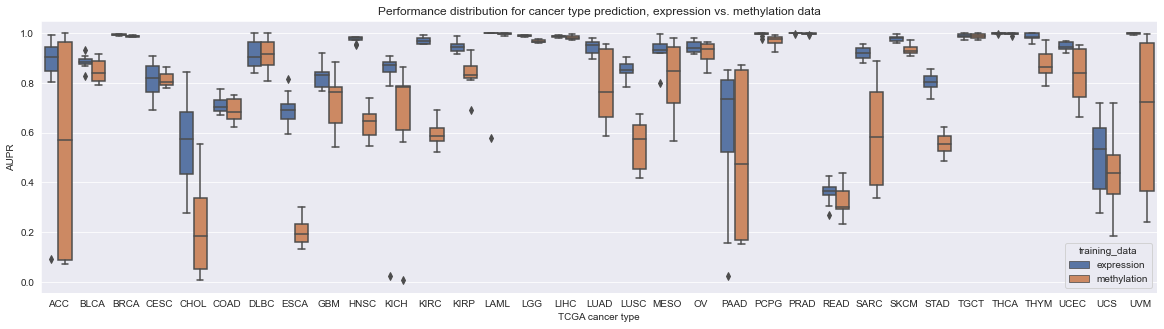

In [4]:
# set this variable to filter plot to certain cancer types
# if not included, plot all 33 of them
# filter_cancer_types = ['LUAD', 'LUSC', 'THCA']
filter_cancer_types = None
if filter_cancer_types is not None:
    filtered_df = results_df[
        (results_df.signal == 'signal') &
        (results_df.data_type == 'test') &
        (results_df.cancer_type.isin(filter_cancer_types))
    ]
else:
    filtered_df = results_df[
        (results_df.signal == 'signal') &
        (results_df.data_type == 'test')
    ].sort_values(by='cancer_type')

sns.set({'figure.figsize': (20, 5)})
sns.boxplot(data=filtered_df, x='cancer_type', y='aupr', hue='training_data',
            hue_order=np.sort(filtered_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('AUPR')
plt.title('Performance distribution for cancer type prediction, expression vs. methylation data')

In [5]:
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='cancer_type',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=sig_alpha,
                                           verbose=True)
expression_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
32,UVM,0.987189,1.965954e-32,6.487650e-31,True
14,LGG,0.932533,8.908975e-32,1.469981e-30,True
15,LIHC,0.947121,5.414586e-31,5.956045e-30,True
22,PRAD,0.943061,4.596693e-30,3.792272e-29,True
28,THCA,0.943469,3.561681e-28,2.350710e-27,True
21,PCPG,0.974578,2.716160e-27,1.493888e-26,True
27,TGCT,0.970647,1.355018e-26,6.387942e-26,True
2,BRCA,0.879973,4.782931e-26,1.972959e-25,True
25,SKCM,0.947655,3.051930e-25,1.119041e-24,True
29,THYM,0.971184,3.676045e-25,1.132516e-24,True


In [6]:
methylation_df = (
    results_df[results_df.training_data == 'methylation']
        .drop(columns=['training_data'])
)
methylation_results_df = au.compare_results(methylation_df,
                                            identifier='cancer_type',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=sig_alpha,
                                            verbose=True)
methylation_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
13,LAML,0.984120,1.763488e-33,5.819512e-32,True
2,BRCA,0.879126,2.829479e-30,4.668641e-29,True
22,PRAD,0.941618,6.055723e-30,6.661296e-29,True
28,THCA,0.942295,1.798243e-28,1.483550e-27,True
15,LIHC,0.942383,1.760944e-27,1.162223e-26,True
14,LGG,0.907483,4.069059e-27,2.237983e-26,True
27,TGCT,0.970310,1.208365e-26,5.696579e-26,True
25,SKCM,0.905640,4.285559e-22,1.767793e-21,True
21,PCPG,0.949205,5.102517e-22,1.870923e-21,True
3,CESC,0.783270,2.721820e-19,8.982008e-19,True


500

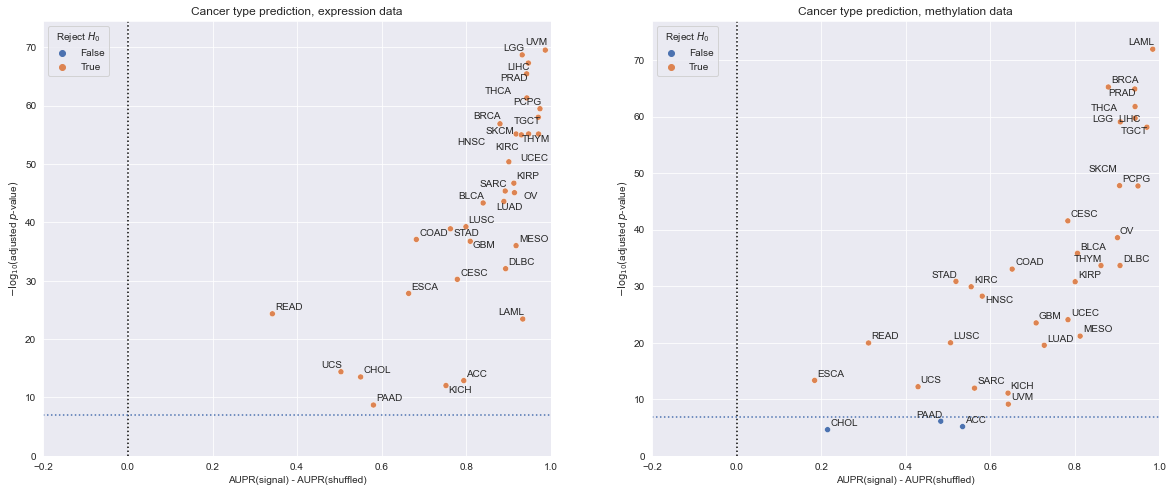

In [7]:
expression_results_df['nlog10_p'] = -np.log(expression_results_df.corr_pval)
methylation_results_df['nlog10_p'] = -np.log(methylation_results_df.corr_pval)

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)
sns.scatterplot(data=expression_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[0])
axarr[0].axvline(x=0, linestyle=':', color='black')
axarr[0].axhline(y=-np.log(sig_alpha), linestyle=':')
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].set_xlim((-0.2, 1.0))
axarr[0].set_ylim((0, expression_results_df.nlog10_p.max() + 5))
axarr[0].legend(title=r'Reject $H_0$')
axarr[0].set_title(r'Cancer type prediction, expression data')
sns.scatterplot(data=methylation_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[1])
axarr[1].axvline(x=0, linestyle=':', color='black')
axarr[1].axhline(y=-np.log(sig_alpha), linestyle=':')
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].set_xlim((-0.2, 1.0))
axarr[1].set_ylim((0, methylation_results_df.nlog10_p.max() + 5))
axarr[1].legend(title=r'Reject $H_0$')
axarr[1].set_title(r'Cancer type prediction, methylation data')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        # if point['sig']:
        text_labels.append(
            ax.text(point['x']+.005, point['y']+.2, str(point['gene']))
        )
    return text_labels
    

text_labels_expression = label_points(expression_results_df['delta_mean'],
                                      expression_results_df['nlog10_p'],
                                      expression_results_df.identifier,
                                      expression_results_df.reject_null,
                                      axarr[0])
adjust_text(text_labels_expression, ax=axarr[0])

text_labels_methylation = label_points(methylation_results_df['delta_mean'],
                                       methylation_results_df['nlog10_p'],
                                       methylation_results_df.identifier,
                                       methylation_results_df.reject_null,
                                       axarr[1])
adjust_text(text_labels_methylation, ax=axarr[1])

In [8]:
compare_results_df = au.compare_results(methylation_df,
                                        pancancer_df=expression_df,
                                        identifier='cancer_type',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=sig_alpha,
                                        verbose=True)
compare_results_df.head()

,identifier,delta_mean,p_value,corr_pval,reject_null
0,LGG,0.023232,7.348924e-08,4.850290e-07,True
1,BLCA,0.034586,1.121691e-01,1.948200e-01,False
2,BRCA,0.005060,1.069603e-02,2.864654e-02,False
3,THCA,0.001804,2.107334e-01,3.023567e-01,False
4,KIRC,0.374143,1.463741e-11,4.830344e-10,True


5

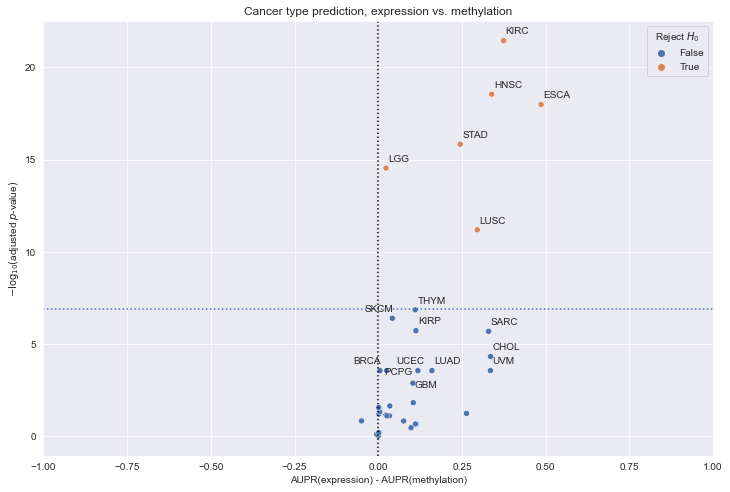

In [9]:
compare_results_df['nlog10_p'] = -np.log(compare_results_df.corr_pval)

sns.set({'figure.figsize': (12, 8)})
sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.axvline(x=0, linestyle=':', color='black')
plt.axhline(y=-np.log(sig_alpha), linestyle=':')
plt.xlabel('AUPR(expression) - AUPR(methylation)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.xlim((-1.0, 1.0))
plt.legend(title=r'Reject $H_0$')
plt.title(r'Cancer type prediction, expression vs. methylation')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log(0.1):
            text_labels.append(
                ax.text(point['x']+.005, point['y']+.2, str(point['gene']))
            )
    return text_labels

text_labels = label_points(compare_results_df['delta_mean'],
                           compare_results_df['nlog10_p'],
                           compare_results_df.identifier,
                           compare_results_df.reject_null,
                           plt.gca())
adjust_text(text_labels, ax=plt.gca())